### Data Exploration and Model Building

Explore relationships between batted ball stats and outcomes.

Explore differences in parks

Build predictive model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('sc2017_batted_ball_filtered.csv')

In [3]:
df.head()

,player_name,stand,events,home_team,launch_angle,launch_speed,barrel
0,Randal Grichuk,R,1B,STL,18.100,109.3,1.0
1,Jose Martinez,R,2B,STL,24.752,104.7,1.0
2,Matt Carpenter,L,OUT,STL,44.199,81.9,0.0
3,Javier Baez,R,OUT,STL,65.349,89.9,0.0
4,Willson Contreras,R,HR,STL,26.617,106.2,1.0


#### Exploratory Data Analysis

- Check how launch angle, launch speed, and barrel affect outcome of AB

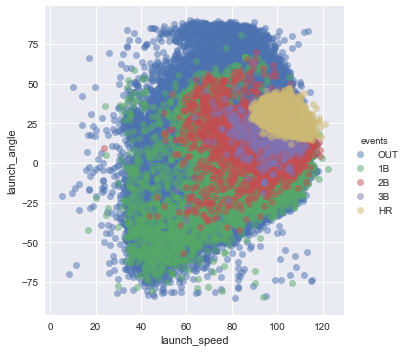

In [4]:
sns.lmplot(x = 'launch_speed', y = 'launch_angle', hue = 'events', data = df, fit_reg = False, 
           hue_order = ['OUT','1B','2B','3B','HR'], scatter_kws = {'alpha': 0.5})

This plot shows one of the biggest issues I'll face when trying to build a predictive model, which is that outs occur at almost all combinations of exit velocity and launch angle. Let's plot each outcome individually to get a better look.

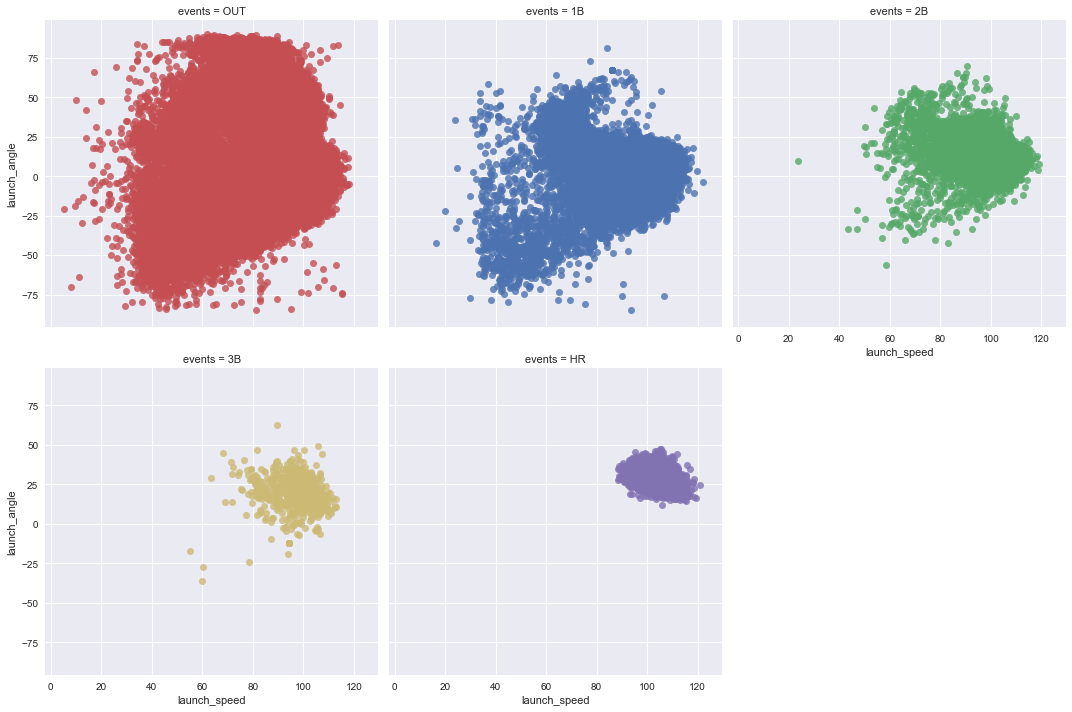

In [5]:
sns.lmplot(x = 'launch_speed', y = 'launch_angle', col = 'events', hue ='events', col_wrap = 3, 
           col_order = ['OUT','1B','2B','3B','HR'], data = df, fit_reg = False)

### Park Effects

Let's see how outcome changes with park. 

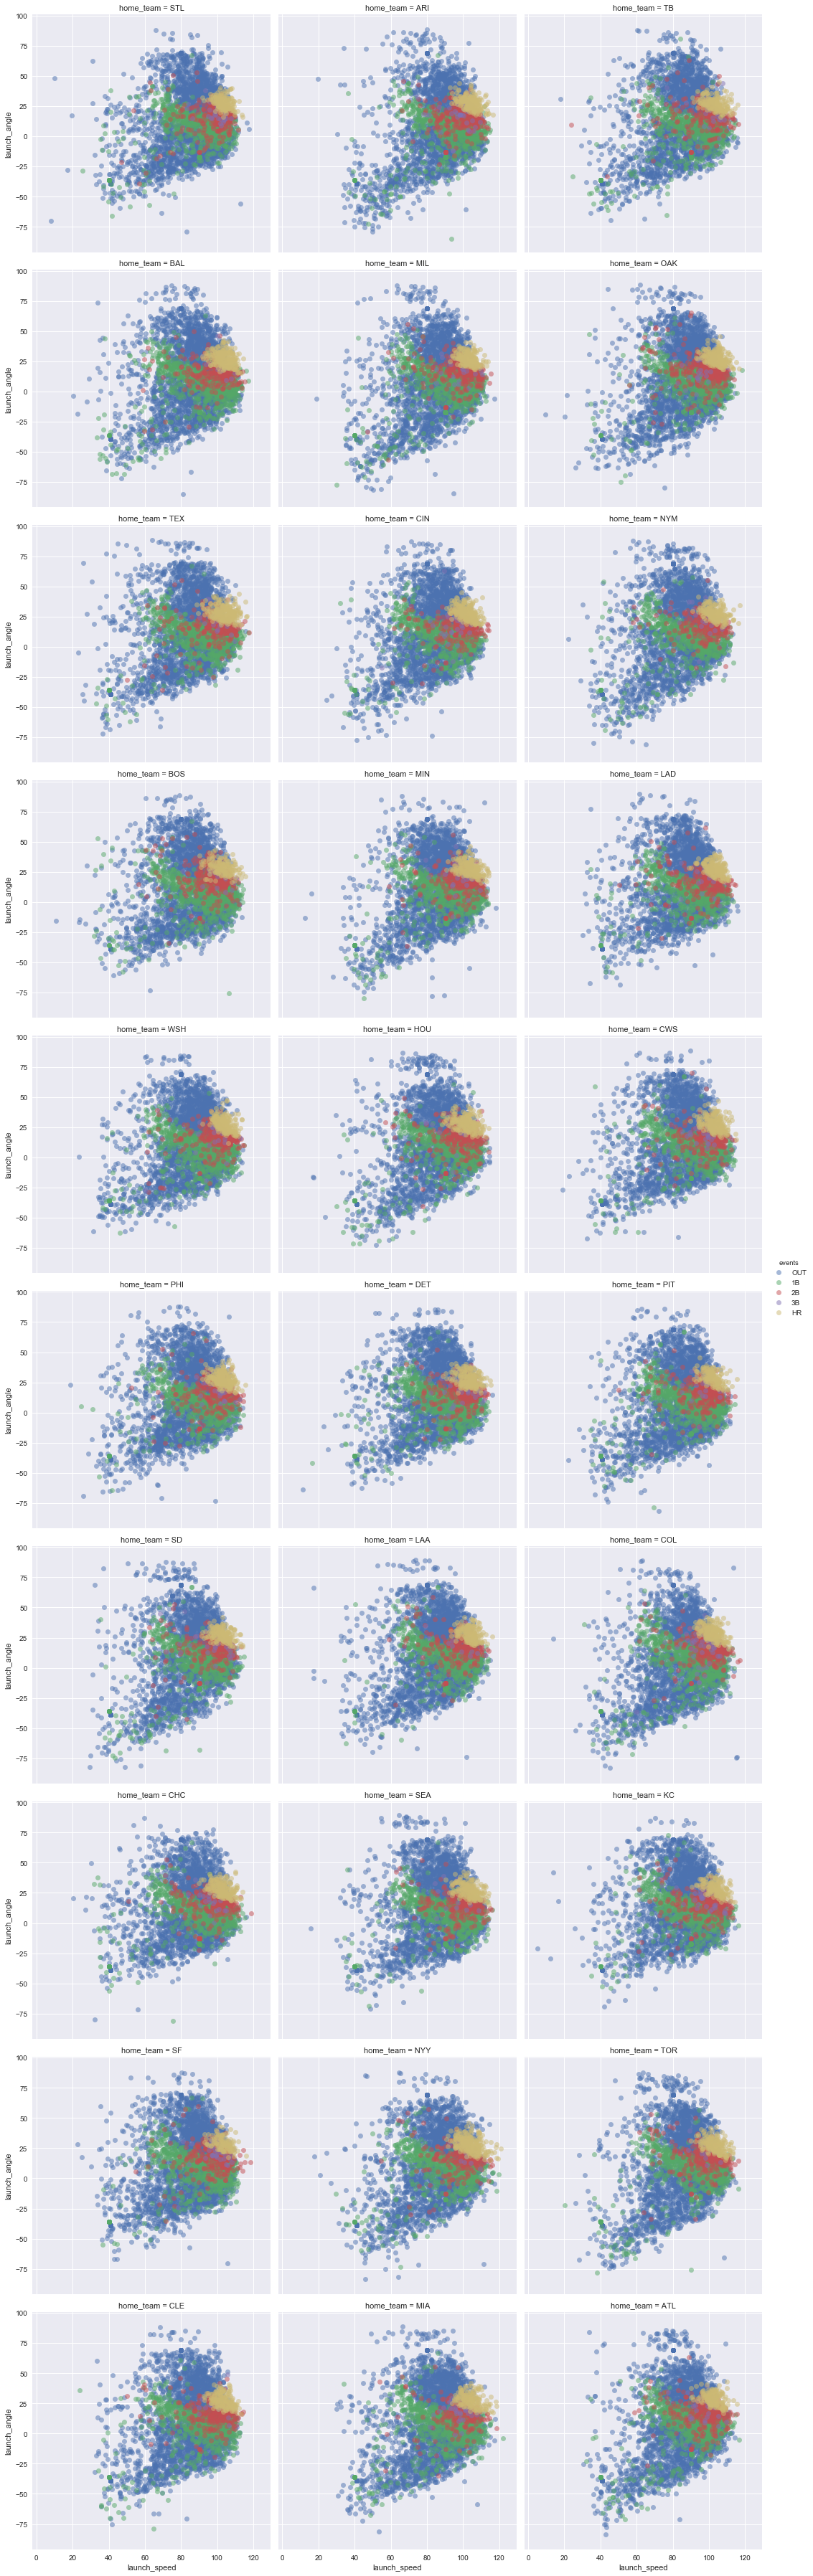

In [6]:
sns.lmplot(x = 'launch_speed', y = 'launch_angle', col = 'home_team', hue ='events', col_wrap = 3,
           hue_order = ['OUT','1B','2B','3B','HR'], data = df, fit_reg = False, scatter_kws = {'alpha': 0.5})

There don't appear to be significant differences. I was hoping that horizontal launch angle would be in the data set as I believe that would provide more differentiation. 

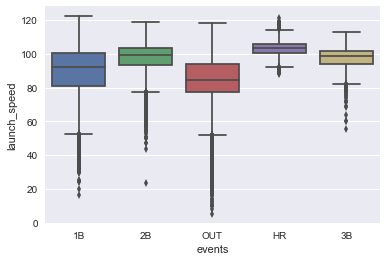

In [7]:
sns.boxplot(x = 'events', y = 'launch_speed', data = df)

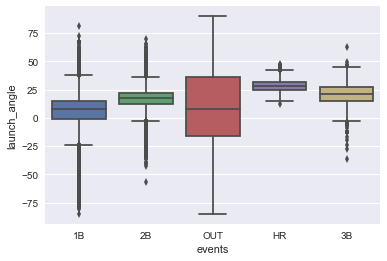

In [8]:
sns.boxplot(x = 'events', y = 'launch_angle', data = df)

### Predictive Model

Let's try to build a model to predict hit type based on launch speed, launch angle, batter handedness, and park. 

In [9]:
#Drop barrel since it is just a subset of angle and speed

df.drop('barrel', axis = 1, inplace = True)
df.head()

,player_name,stand,events,home_team,launch_angle,launch_speed
0,Randal Grichuk,R,1B,STL,18.100,109.3
1,Jose Martinez,R,2B,STL,24.752,104.7
2,Matt Carpenter,L,OUT,STL,44.199,81.9
3,Javier Baez,R,OUT,STL,65.349,89.9
4,Willson Contreras,R,HR,STL,26.617,106.2


In [10]:
#Save player name in a separate df
names = df['player_name']
df.drop('player_name', axis = 1, inplace = True)

In [11]:
#Separate 'events' as dependent variable
Y = df['events']
df.drop('events', axis = 1, inplace = True)

### Preprocessing the Data

Before building a model, I need to encode my categorical variables and normalize launch_angle and launch_speed. 

In [12]:
#Standardize launch_angle and launch_speed
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['launch_angle','launch_speed']] = scaler.fit_transform(df[['launch_angle','launch_speed']])

In [13]:
df.head()

,stand,home_team,launch_angle,launch_speed
0,R,STL,0.255639,1.493118
1,R,STL,0.496918,1.191087
2,L,STL,1.202293,-0.305936
3,R,STL,1.969439,0.219335
4,R,STL,0.564564,1.289576


In [14]:
#One-hot encode all categorical variables

#Y = pd.get_dummies(Y)

In [15]:
Y.head()

0     1B
1     2B
2    OUT
3    OUT
4     HR
Name: events, dtype: object

In [16]:
df = pd.get_dummies(df, columns = ['stand','home_team'])

In [17]:
df.head()

,launch_angle,launch_speed,stand_L,stand_R,home_team_ARI,home_team_ATL,home_team_BAL,home_team_BOS,home_team_CHC,home_team_CIN,...,home_team_PHI,home_team_PIT,home_team_SD,home_team_SEA,home_team_SF,home_team_STL,home_team_TB,home_team_TEX,home_team_TOR,home_team_WSH
0,0.255639,1.493118,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.496918,1.191087,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.202293,-0.305936,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1.969439,0.219335,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.564564,1.289576,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### Split into testing and training sets

Stratify by Y to ensure that each hit type is proportionally represented in the training set

In [18]:
#Split df in testing and training sets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

X_train, X_test, Y_train, Y_test = train_test_split(df, Y, test_size = 0.25, stratify = Y, random_state = 42)

### Predictive Modeling

- Multinomial logistic regression
- Kernel SVM
- Random Forest
- Naive Bayes?

#### Logistic Regression

- Multinomial

In [19]:
from sklearn.linear_model import LogisticRegressionCV

In [20]:
lr_cv_default = LogisticRegressionCV()

In [21]:
lr_cv_default_fit = lr_cv_default.fit(X_train, Y_train)

In [22]:
lr_cv_default_fit.score(X_test, Y_test)

0.67553956834532369

In [23]:
lr_cv_multinomial = LogisticRegressionCV(multi_class='multinomial')

In [ ]:
lr_cv_multinomial_fit = lr_cv_default.fit(X_train, Y_train)
lr_cv_multinomial_fit.score(X_test, Y_test)

0.67553956834532369

### RBF Kernel SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

parameters = {'C':[.01,.1,1,10], 'gamma':[.01,.1,1,10]}
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
svc = svm.SVC()
svm_GS = GridSearchCV(svc, parameters)
svm_GS_fit = svm_GS.fit(X_train, Y_train)

print("The best parameters are %s with a score of %0.2f"
      % (svm_GS_fit.best_params_, svm_GS_fit.best_score_))

In [ ]:
#Recreate model with probability = True to allow model to output log probabilities

#svm_rbf = svm.SVC(C = 1, gamma = 100, probability = True)
#svm_rbf_fit = svm_rbf.fit(x_train, y_train)

In [ ]:
#Confusion matrix on test set

#pd.crosstab(y_test, svm_rbf_fit.predict(x_test), rownames=['True'], colnames=['Predicted'])

### Calculating Predicted wOBA

For each hit I'll use the model to generate the probability of each result, and multiply by their respective wOBA weights to get an expected wOBA.    

In [ ]:
#Get 2017 wOBA weights from Fangraphs

wOBA_2017 = {'1B': .877, 
             '2B': 1.232, 
             '3B': 1.552, 
             'HR': 1.980}

In [ ]:
#Calculate pwOBA for each hit



